# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration
## 1. Exploring the portfolio dataframe

In [2]:
portfolio.head(10).sort_values(by=['offer_type'])

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
3       5          [web, email, mobile]           5         7           bogo   
8       5  [web, email, mobile, social]           5         5           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
9       2          [web, email, mobile]          10         7       discount   
2       0          [web, email, mobile]           0         4  informational   
7       0       [email, mobile, social]           0         3  informational   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
8  f19421c1d4aa40978ebb69ca19b0e20d  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
9  2906b810c7d4411798c6938adc9daaa5  
2  3f207df678b143eea3cee63160fa8bed  
7  5a8bc65990b245e5a138643cd4eb9837

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.describe()

reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
def plot_categories(df, colName, title, figsize=[5,5], bInvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    title: The plot title.
    
    figsize: The figure size of the plot (default is [5,5]).
    
    bInvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    
    fntSize: The font size of text (default to 12 point font size)
    
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=figsize)
    fig, ax = plt.subplots()    
    y_counts = df[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(title)

<Figure size 360x360 with 0 Axes>

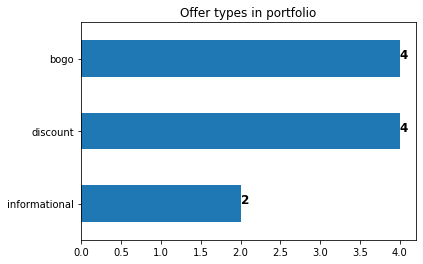

In [7]:
plot_categories(portfolio, 'offer_type', "Offer types in portfolio")

<Figure size 360x360 with 0 Axes>

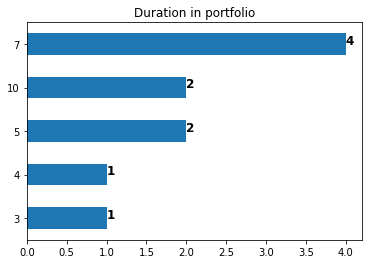

In [8]:
plot_categories(portfolio, 'duration', "Duration in portfolio")

## 2. Exploring the profile dataframe

In [9]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [10]:
profile.shape

(17000, 5)

In [11]:
profile.describe(include="all")

gender           age                                id  \
count   14825  17000.000000                             17000   
unique      3           NaN                             17000   
top         M           NaN  577dbfb64274452ab6b330346f7fdcf0   
freq     8484           NaN                                 1   
mean      NaN     62.531412                               NaN   
std       NaN     26.738580                               NaN   
min       NaN     18.000000                               NaN   
25%       NaN     45.000000                               NaN   
50%       NaN     58.000000                               NaN   
75%       NaN     73.000000                               NaN   
max       NaN    118.000000                               NaN   

        became_member_on         income  
count       1.700000e+04   14825.000000  
unique               NaN            NaN  
top                  NaN            NaN  
freq                 NaN            NaN  
mean        2.016703e+07   65404.991568  
std         1.167750e+04   21598.299410  
min         2.013073e+07   30000.000000  
25%         2.016053e+07   49000.000000  
50%         2.017080e+07   64000.000000  
75%         2.017123e+07   80000.000000  
max         2.018073e+07  120000.000000

Looks the max value for age is 118 in the dataframe, which seems to be some entry error and need to be processed later

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
#check for null values 
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile[profile['age']== 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

looks the null values for gender and income are all from rows with age == 118, we consider this as data entry error, will replace these with mean values

In [15]:
#check for different age values
profile.age.value_counts()
print(profile.age.value_counts().sort_index().tail(50))

53      372
54      359
55      350
56      342
57      353
58      408
59      359
60      333
61      309
62      318
63      338
64      311
65      280
66      284
67      317
68      259
69      242
70      252
71      230
72      191
73      209
74      193
75      159
76      155
77      141
78      135
79      117
80      116
81      118
82      105
83      102
84       83
85       70
86       54
87       66
88       64
89       53
90       52
91       47
92       40
93       29
94       33
95       22
96        8
97       13
98        5
99        5
100      12
101       5
118    2175
Name: age, dtype: int64


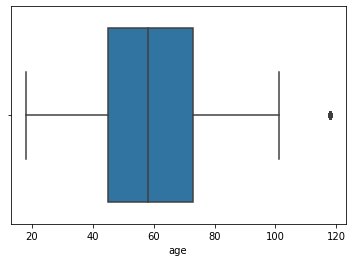

In [16]:
#create a boxplot to find the outliers in our data frame
sns.boxplot(profile['age'])

It looks that people with age greater than 75 to 80 don't interact with the app much. Thus people with the above age are considered as outliers.

<Figure size 360x360 with 0 Axes>

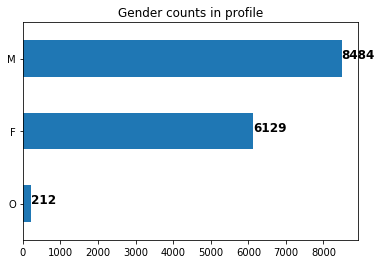

In [17]:
#Print gender counts in plot
plot_categories(profile, 'gender', "Gender counts in profile")

In [18]:
def pie_plot(df, colName, title, colors=[], labels=[], explode=(), figSize=[5, 5]):
    """
    Creates an exploded pie plot with percentages of each categories for the column provided.
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    title: The plot title.
    
    colors: The array of colors to use.
    
    labels: The array of plot labels to use for each of the categories.
    
    explode: The proportions to pass in for exploding the slices (e.g. 0.1, 0, 0 will explode the first category out by 10%)
    
    figSize: The figure size of the plot (default is [5,5])
    
    Returns
    -------
    None
    """
    plt.figure(figsize=[5, 5])
    values = df[colName].value_counts()
    plt.pie(values, colors=colors, labels=labels, explode=explode, autopct='%1.2f%%', counterclock=False, shadow=True)
    plt.title(title)

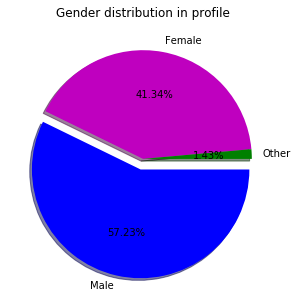

In [19]:
pie_plot(profile, 'gender', 'Gender distribution in profile', ['b', 'm', 'g'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

## 3. Exploring the transcript dataframe

In [20]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [21]:
transcript.shape

(306534, 4)

In [22]:
transcript.describe(include="all")

person        event  \
count                             306534       306534   
unique                             17000            4   
top     94de646f7b6041228ca7dec82adb97d2  transaction   
freq                                  51       138953   
mean                                 NaN          NaN   
std                                  NaN          NaN   
min                                  NaN          NaN   
25%                                  NaN          NaN   
50%                                  NaN          NaN   
75%                                  NaN          NaN   
max                                  NaN          NaN   

                                                   value           time  
count                                             306534  306534.000000  
unique                                              5121            NaN  
top     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}            NaN  
freq                                               14983            NaN  
mean                                                 NaN     366.382940  
std                                                  NaN     200.326314  
min                                                  NaN       0.000000  
25%                                                  NaN     186.000000  
50%                                                  NaN     408.000000  
75%                                                  NaN     528.000000  
max                                                  NaN     714.000000

In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [25]:
transcript.value.value_counts().head(20)

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

There are 4 possible values in transcript values including 'offer id', 'offer_id', 'reward' and 'amount'. 

<Figure size 360x360 with 0 Axes>

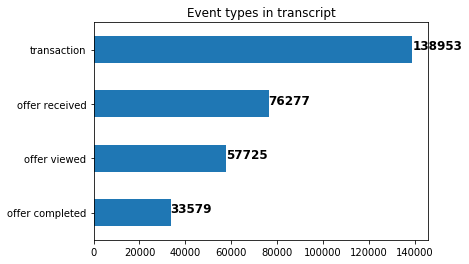

In [26]:
plot_categories(transcript, 'event', "Event types in transcript")

# Data Preparation and Cleaning
## 1. Cleaning portfolio dataframe

Renaming column names for better understanding and for dataframe merge later

In [27]:
def rename_cols(df, new_cols_name):
    """
    Parameters
    ----------
    df: input dataframe for renaming columns
    new_cols_name: define new column name for each column using a dictionary
    
    Returns
    -------
    df: output data frame with renamed column names
       
    """

    df= df.rename(columns = new_cols_name)
    return df

In [28]:
#rename columns
portfolio_new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
cleaned_portfolio = rename_cols(portfolio, portfolio_new_cols_name )

In [29]:
cleaned_portfolio.head()

offer_reward                      channels  offer_difficulty  \
0            10       [email, mobile, social]                10   
1            10  [web, email, mobile, social]                10   
2             0          [web, email, mobile]                 0   
3             5          [web, email, mobile]                 5   
4             5                  [web, email]                20   

   offer_duration     offer_type                          offer_id  
0               7           bogo  ae264e3637204a6fb9bb56bc8210ddfd  
1               5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0  
2               4  informational  3f207df678b143eea3cee63160fa8bed  
3               7           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4              10       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7

## 2. Cleaning Profile

Clean up profile dataframe for following steps:
1.Rename column names for better understanding and for dataframe merge later
2.Impute data so that we do not have to remove data with null values.
  Impute missing age and income with mean value and impute missing gender values with mode
3.Consider customer with age greater than 75/80 as outliers, will remove accordingly from dataset
4.Classify ages into age groups

In [30]:
#rename columns
profile_new_cols_name = {'id':'customer_id' , 'income':'customer_income'}
cleaned_profile = rename_cols(profile, profile_new_cols_name )

In [31]:
def cleaning_profile(df):
    """
    Clean the profile data frame 
        
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per tasks
    """
    
    # deal with null values
    # we consider 118 age is entry error, replace it with mean age
    df.replace(118, np.nan , inplace=True)
    # replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    # replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    # replace missing gender values with mode - most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    # remove outliers - age >= 80
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df.age < 20) , 'age_group'] = 'under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [32]:
cleaned_profile = cleaning_profile(cleaned_profile)

In [33]:
cleaned_profile.head()

gender                       customer_id  became_member_on  customer_income  \
0      M  68be06ca386d4c31939f3a4f0e3dd783          20170212     65404.991568   
1      F  0610b486422d4921ae7d2bf64640c50b          20170715    112000.000000   
2      M  38fe809add3b4fcf9315a9694bb96ff5          20180712     65404.991568   
3      F  78afa995795e4d85b5d9ceeca43f5fef          20170509    100000.000000   
4      M  a03223e636434f42ac4c3df47e8bac43          20170804     65404.991568   

  age_group  
0     46-60  
1     46-60  
2     46-60  
3     61-80  
4     46-60

In [34]:
#check for missing values 
cleaned_profile.isnull().sum()

gender              0
customer_id         0
became_member_on    0
customer_income     0
age_group           0
dtype: int64

We don't have any null values in cleaned profile dataframe now.

## 3. Cleaning Transcript

1.Rename column names for better understanding and for dataframe merge later
2.Convert value column into new columns using the keys of it

In [35]:
#rename columns
transcript_new_cols_name = {'person':'customer_id'}
cleaned_transcript = rename_cols(transcript, transcript_new_cols_name)

In [36]:
cleaned_transcript.event.value_counts().head(20)

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [37]:
cleaned_transcript.head()

customer_id           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [38]:
def cleaning_transcript(df):
    """
    Cleaning the transcript data frame
    
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    
    #expand the dictionary to coulmns 
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [39]:
cleaned_transcript = cleaning_transcript(cleaned_transcript)

In [40]:
cleaned_transcript.head()

customer_id           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  money_gained  money_spent  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9           0.0          0.0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7           0.0          0.0  
2  2906b810c7d4411798c6938adc9daaa5           0.0          0.0  
3  fafdcd668e3743c1bb461111dcafc2a4           0.0          0.0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0           0.0          0.0

In [41]:
cleaned_transcript.isnull().sum()

customer_id     0
event           0
time            0
offer_id        0
money_gained    0
money_spent     0
dtype: int64

# Explore Data

Clean merged dataframe before doing exploration

In [42]:
merged_df = pd.merge(cleaned_portfolio, cleaned_transcript, on='offer_id')

In [43]:
merged_df = pd.merge(merged_df, cleaned_profile, on='customer_id')

In [44]:
merged_df.head()

offer_reward                 channels  offer_difficulty  offer_duration  \
0            10  [email, mobile, social]                10               7   
1            10  [email, mobile, social]                10               7   
2            10  [email, mobile, social]                10               7   
3            10  [email, mobile, social]                10               7   
4            10  [email, mobile, social]                10               7   

  offer_type                          offer_id  \
0       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
1       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
2       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
3       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
4       bogo  ae264e3637204a6fb9bb56bc8210ddfd   

                        customer_id            event  time  money_gained  \
0  4b0da7e80e5945209a1fdddfe813dbe0   offer received     0           0.0   
1  4b0da7e80e5945209a1fdddfe813dbe0     offer viewed   102           0.0   
2  4b0da7e80e5945209a1fdddfe813dbe0   offer received   504           0.0   
3  4b0da7e80e5945209a1fdddfe813dbe0     offer viewed   510           0.0   
4  4b0da7e80e5945209a1fdddfe813dbe0  offer completed   510          10.0   

   money_spent gender  became_member_on  customer_income age_group  
0          0.0      M          20170909         100000.0     61-80  
1          0.0      M          20170909         100000.0     61-80  
2          0.0      M          20170909         100000.0     61-80  
3          0.0      M          20170909         100000.0     61-80  
4          0.0      M          20170909         100000.0     61-80

To get better understanding of the relation between offers and customers, I would like to look at following aspects of data.

## 1. Average income of Starbucks customers

Average income of customers:  65924.49109976116


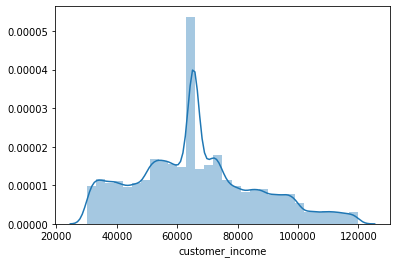

In [45]:
print('Average income of customers: ', merged_df['customer_income'].mean())
sns.distplot(merged_df['customer_income'], bins=30, hist_kws={'alpha': 0.4});

## 2.Age distribution of Starbucks customers

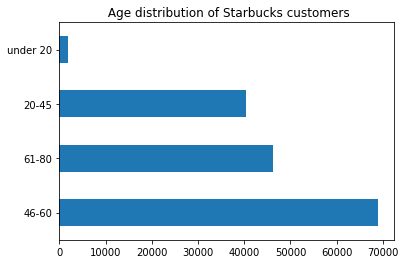

In [46]:
merged_df['age_group'].value_counts().plot.barh(title=' Age distribution of Starbucks customers')

## 3.Gender Distribution in general/ in age group/in offer type/in event

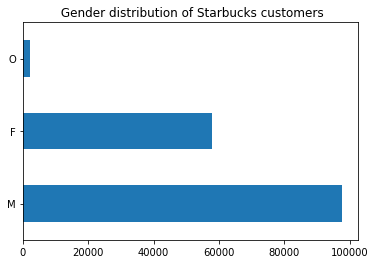

In [47]:
merged_df['gender'].value_counts().plot.barh(title=' Gender distribution of Starbucks customers')

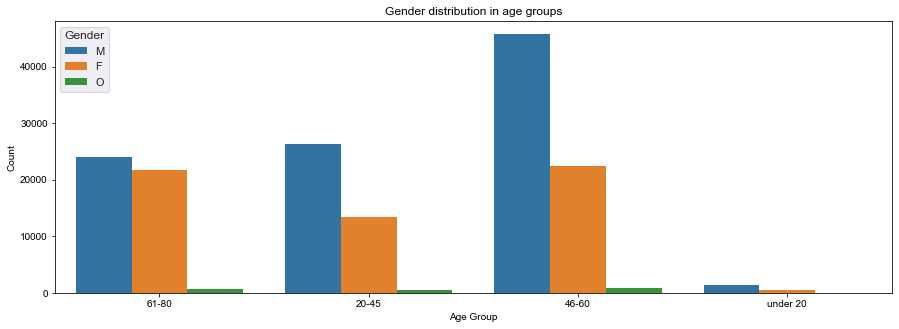

In [48]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "gender", data=merged_df)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

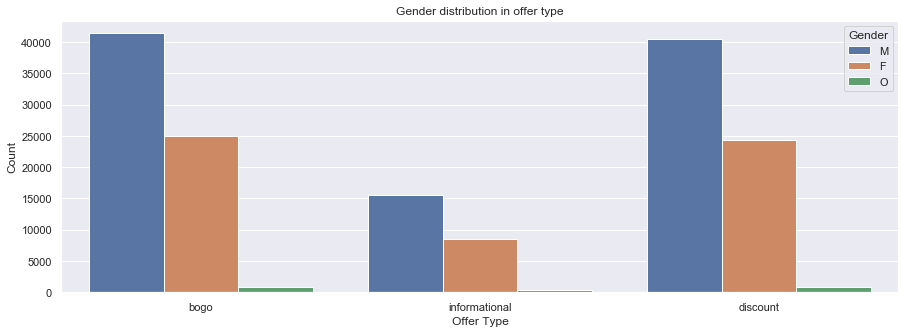

In [49]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=merged_df)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer type')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

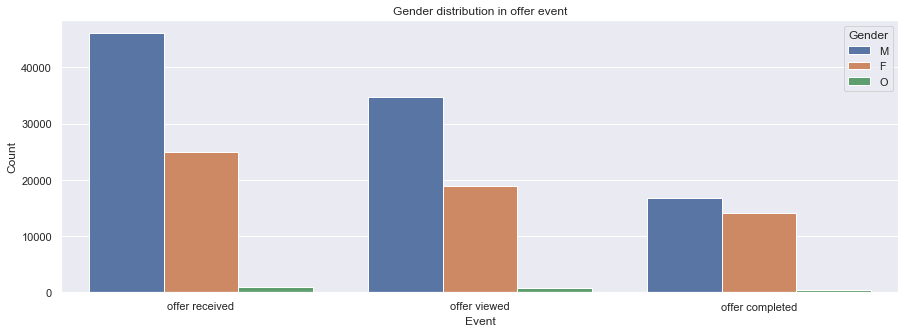

In [50]:
# event offer completed
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=merged_df)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer event')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

We could see from here that famale is more likely to complete a given offer than male in general, other gender type is not considered in this case due to huge difference of size.

## 4.Actions to the offers that customers received

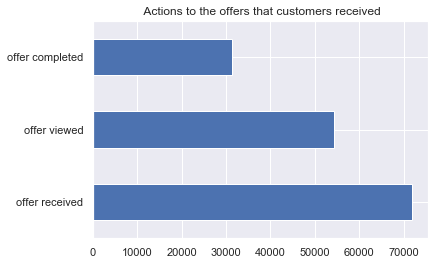

In [51]:
merged_df['event'].value_counts().plot.barh(title=' Actions to the offers that customers received')

## 5.Actions to the offers in each offer type

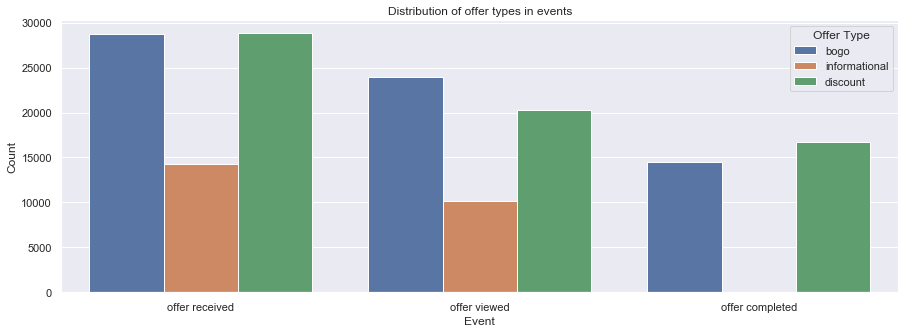

In [52]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_df)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

## 6.Actions to the offers in each age group

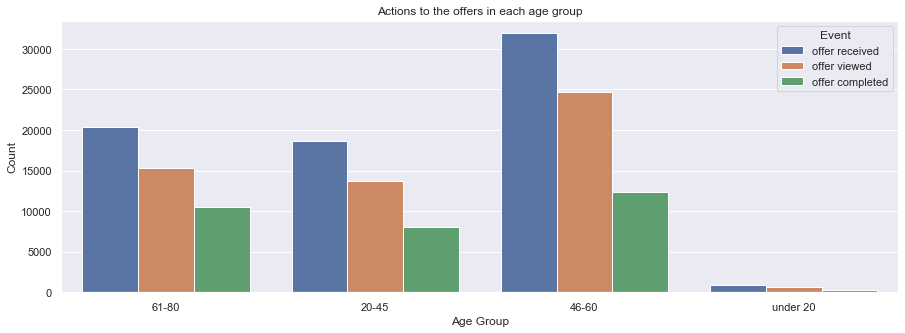

In [53]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "event", data=merged_df)
sns.set(style="darkgrid")
plt.title('Actions to the offers in each age group')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

# Build a Machine Learning Model

## 1.Clean dataframe

Process merged dataframe for following columns:
Create dummy columns for categorical data including: gender, offer type, channel and age groups.
Encode the 'event' data to numerical values
Encode offer id and customer id.
Convert column 'became_member_on' into columns for month and year.
Scale and normalize numerical data.

In [54]:
def cleaning_final_data(df):
    """
    Clean merged data frame
    
    Parameters
    ----------
    df: input data frame
    
    Returns
    -------
    df: cleaned data frame as per tasks
       
    """
    #process categorical variables
    categorical = ['offer_type', 'gender', 'age_group']
    df = pd.get_dummies(df, columns = categorical)
    #process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #process became_member_on column
    #change datatype of became_member_on 
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [55]:
cleaned_data = cleaning_final_data(merged_df)

In [56]:
cleaned_data.head()

offer_reward  offer_difficulty  offer_duration  offer_id  customer_id  \
0           1.0               0.5        0.571429         0            0   
1           1.0               0.5        0.571429         0            0   
2           1.0               0.5        0.571429         0            0   
3           1.0               0.5        0.571429         0            0   
4           1.0               0.5        0.571429         0            0   

   event      time  money_gained  money_spent  customer_income  ...  \
0      1  0.000000           0.0          0.0         0.777778  ...   
1      2  0.142857           0.0          0.0         0.777778  ...   
2      1  0.705882           0.0          0.0         0.777778  ...   
3      2  0.714286           0.0          0.0         0.777778  ...   
4      3  0.714286           1.0          0.0         0.777778  ...   

   age_group_20-45  age_group_46-60  age_group_61-80  age_group_under 20  \
0                0                0                1                   0   
1                0                0                1                   0   
2                0                0                1                   0   
3                0                0                1                   0   
4                0                0                1                   0   

   email  mobile  social  web  month_member  year_member  
0      1       1       1    0             9         2017  
1      1       1       1    0             9         2017  
2      1       1       1    0             9         2017  
3      1       1       1    0             9         2017  
4      1       1       1    0             9         2017  

[5 rows x 26 columns]

## 2.Split cleaned data into training and testing datasets

We will now split cleaned data into training dataset (80%) and testing dataset (20%)

In [57]:
data = cleaned_data.drop('event', axis=1)
label = cleaned_data['event']
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 0)

print("Training dataset size: {}".format(X_train.shape[0]))
print("Testing dataset size: {}".format(X_test.shape[0]))

Training dataset size: 126002
Testing dataset size: 31501


## 3.Training and testing

We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [ ]:
def print_model_scores(model, train_f1, test_f1):
    knn = {'Model': [ model], 'train F1 score':[train_f1], 'test F1 score': [test_f1]}
    res = pd.DataFrame(knn)
    print(res)

In [146]:
def train_test(clf):
    """
    Return train and test F1 score and model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    clf.fit(X_train, y_train)
    train_pred =  clf.predict(X_train)
    test_pred = clf.predict(X_test)
    
    train_f1 =  accuracy_score(y_train, train_pred) * 100
    test_f1= fbeta_score(y_test, test_pred, beta = 0.5, average='micro' )*100
    
    name = clf.__class__.__name__
    print_model_scores(name, train_f1, test_f1)
    
    return train_f1, test_f1, name

### KNeighborsClassifier

As a start, K-Nearest Neighbors algorithm is used and evaluate the model result by the F1 score metric.

In [147]:
clf_1 = KNeighborsClassifier(n_neighbors = 5)
train_f1_1, test_f1_1, model_1 = train_test(clf_1)
# print_model_scores(model_1, train_f1_1, test_f1_1)

                  Model  train F1 score  test F1 score
0  KNeighborsClassifier       51.399978      28.767341


Both train and test F1 scores are not very good. Other alogrithms will be introduced and the results will be compared against eachother.

### RandomForestClassifier

In [148]:
clf_2 = RandomForestClassifier(random_state = 42)
train_f1_2, test_f1_2, model_2 = train_test(clf_2)
# print_model_scores(model_2, train_f1_2, test_f1_2)

                    Model  train F1 score  test F1 score
0  RandomForestClassifier       93.053285      68.658138


### DecisionTreeClassifier

In [149]:
clf_3 = DecisionTreeClassifier(random_state = 42)
train_f1_3, test_f1_3, model_3 = train_test(clf_3)
# print_model_scores(model_3, train_f1_3, test_f1_3)

                    Model  train F1 score  test F1 score
0  DecisionTreeClassifier       93.941366      84.813181


## 4.Hyperparameter Tuning

In [ ]:
The models can have many hyperparameters and finding the best combination of the parameter using grid search methods.

### What is Grid Search?

Grid search is a technique for tuning hyperparameter that may facilitate build a model and evaluate a model for every combination of algorithms parameters per grid.
We might use 10 fold cross-validation to search the best value for that tuning hyperparameter. Parameters like in decision criterion, max_depth, min_sample_split, etc. These values are called hyperparameters. To get the simplest set of hyperparameters we will use the Grid Search method. In the Grid Search, all the mixtures of hyperparameters combinations will pass through one by one into the model and check the score on each model. It gives us the set of hyperparameters which gives the best score. Scikit-learn package as a means of automatically iterating over these hyperparameters using cross-validation. This method is called Grid Search.

### How does it work?

Grid Search takes the model or objects you’d prefer to train and different values of the hyperparameters. It then calculates the error for various hyperparameter values, permitting you to choose the best values.

We will apply gridSearch to improve the performance of our best model so far, which is the decison tree model.

### parameter for gridsearchcv

In [63]:
# Look at parameters used by our current decison tree model
clf_3.get_params()

Parameters currently in use:



{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 10,
 'splitter': 'best'}

A good place to learn about most important settings for decision tree is the documentation in Scikit-Learn. 
We can learn include the following: 
1.max_depth: it controls size of the tree and prevent overfitting
2.min_samples_split/min_samples_leaf: it ensures that multiple samples inform every decision in the tree, by controlling which splits will be considered. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. Try min_samples_leaf=5 as an initial value. If the sample size varies greatly, a float number can be used as percentage in these two parameters. While min_samples_split can create arbitrarily small leaves, min_samples_leaf guarantees that each leaf has a minimum size, avoiding low-variance, over-fit leaf nodes in regression problems. For classification with few classes, min_samples_leaf=1 is often the best choice.

We could go read the research papers on the decision tree and try to theorize the best hyperparameters, but a more efficient use of our time is just to try out a wide range of values and see what works! We will try adjusting the following set of hyperparameters:
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
criterion = the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain

### Finding best hyperparameter using gridsearchcv

First, we import the libraries that we need, including GridSearchCV, the dictionary of parameter values. We create a decision tree model. We then create a GridSearchCV object. The inputs are the decision tree object, the parameter values, and the number of folds. We will use classification performance metrics. This is the default scoring method. We fit the object. We can find the best values for the parameters using the attribute best estimator.
advantages of Grid Search is how quickly we can test multiple parameters.

In [162]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 100, num = 10)],
    'min_samples_leaf': list(range(1,10)),
    'min_samples_split': list(range(2,10)),
    'criterion': ['gini','entropy']
}
print(param_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'criterion': ['gini', 'entropy']}


This will try out 10 * 9 * 8 * 2 = 1440 combinations of settings. 

In [163]:
# Create a based model
rf = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = 4, verbose = 2)


In this above code, the decision is an estimator implemented using sklearn. The parameter cv is the cross-validation method if this parameter is set to be None, to use the default 5-fold cross-validation. The parameter verbose controls the verbosity and the parameter n_jobs is the number of jobs to run in parallel. none means 1 unless in a joblib.parallel_backend context. 4 means using 4 processors.

In [164]:
# Train the grid search model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   46.3s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 17.8min
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed: 21.4min
[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed: 26.0min
[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed: 31.7min
[Parallel(n_jobs=4)]: Done 7200 out of 7200 | elapsed: 33.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],

### Find the best hyperparameter

After we have fit the model we can find the best values for the parameters using the attribute best estimator.

In [165]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 9,
 'min_samples_split': 9}

### Evaluate Tuned Model

We want to verify if the best hyperparameters yielded a better model, we compare the base model with the grid search model with best parameters.

In [167]:
# run train and test data using base DecisionTree model 
base_model = DecisionTreeClassifier(random_state = 42)
train_test(base_model)

# run train and test data using DecisionTree model with best parameters
best_model = grid_search.best_estimator_
train_f1_best, test_f1_best, model_best = train_test(best_estimator)

                    Model  train F1 score  test F1 score
0  DecisionTreeClassifier       93.941366      84.813181
                    Model  train F1 score  test F1 score
0  DecisionTreeClassifier       92.346947      92.117711


Looks the F1 score has been improved a lot from 84 to 92, we will discuss more in conclusions.

# Conclusions

## 1.EDA

In [57]:
merged_df.head()

offer_reward                 channels  offer_difficulty  offer_duration  \
0            10  [email, mobile, social]                10               7   
1            10  [email, mobile, social]                10               7   
2            10  [email, mobile, social]                10               7   
3            10  [email, mobile, social]                10               7   
4            10  [email, mobile, social]                10               7   

  offer_type                          offer_id  \
0       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
1       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
2       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
3       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
4       bogo  ae264e3637204a6fb9bb56bc8210ddfd   

                        customer_id            event  time  money_gained  \
0  4b0da7e80e5945209a1fdddfe813dbe0   offer received     0           0.0   
1  4b0da7e80e5945209a1fdddfe813dbe0     offer viewed   102           0.0   
2  4b0da7e80e5945209a1fdddfe813dbe0   offer received   504           0.0   
3  4b0da7e80e5945209a1fdddfe813dbe0     offer viewed   510           0.0   
4  4b0da7e80e5945209a1fdddfe813dbe0  offer completed   510          10.0   

   money_spent gender  became_member_on  customer_income age_group  
0          0.0      M          20170909         100000.0     61-80  
1          0.0      M          20170909         100000.0     61-80  
2          0.0      M          20170909         100000.0     61-80  
3          0.0      M          20170909         100000.0     61-80  
4          0.0      M          20170909         100000.0     61-80

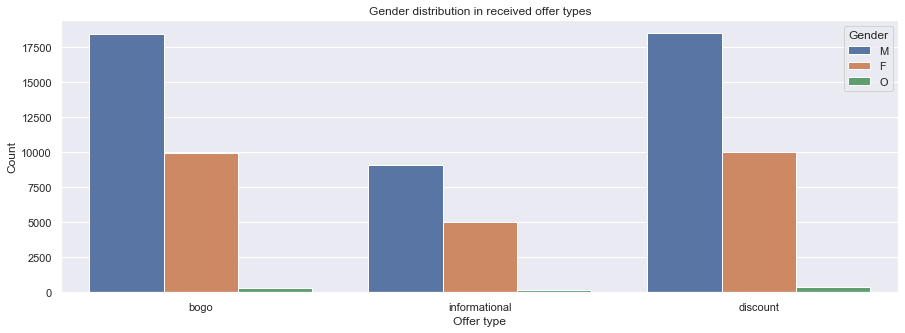

In [78]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=merged_df[merged_df['event'] == 'offer received'])
sns.set(style="darkgrid")
plt.title('Gender distribution in received offer types')
plt.ylabel('Count')
plt.xlabel('Offer type')
plt.legend(title='Gender')

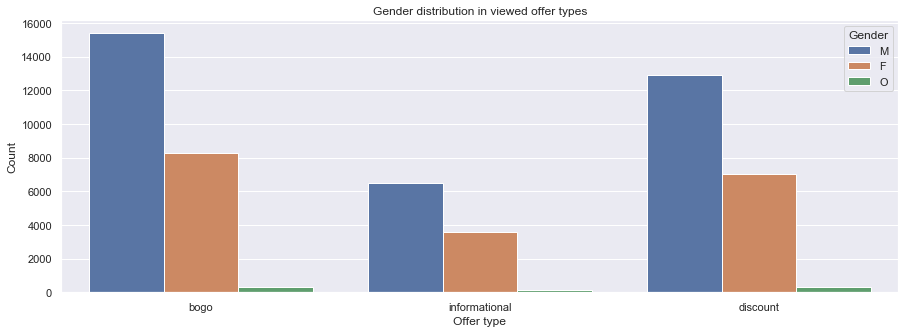

In [79]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=merged_df[merged_df['event'] == 'offer viewed'])
sns.set(style="darkgrid")
plt.title('Gender distribution in viewed offer types')
plt.ylabel('Count')
plt.xlabel('Offer type')
plt.legend(title='Gender')

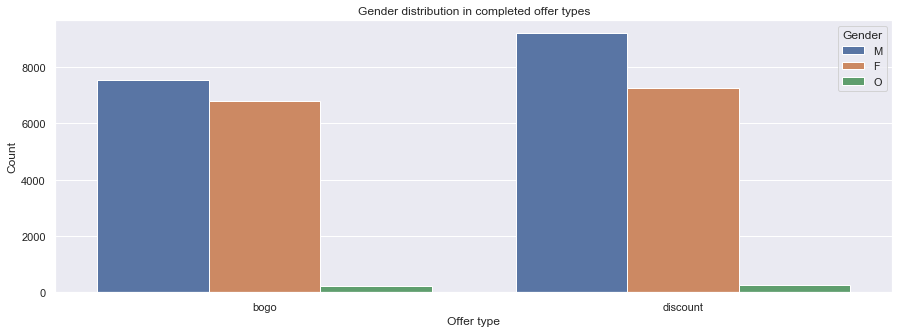

In [86]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=merged_df[merged_df['event'] == 'offer completed'])
sns.set(style="darkgrid")
plt.title('Gender distribution in completed offer types')
plt.ylabel('Count')
plt.xlabel('Offer type')
plt.legend(title='Gender')

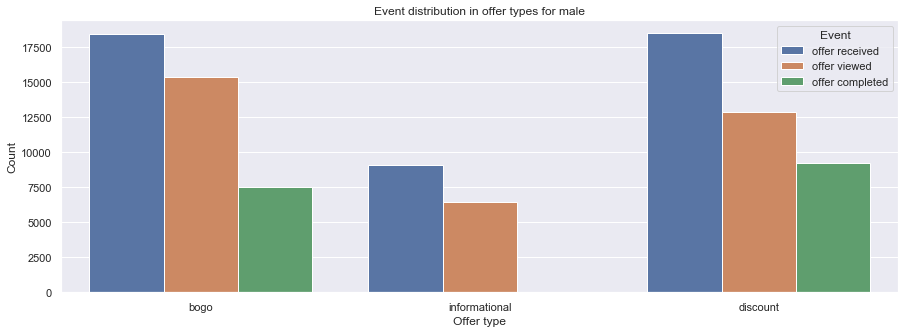

In [84]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "event", data=merged_df[merged_df['gender'] == 'M'])
sns.set(style="darkgrid")
plt.title('Event distribution in offer types for male')
plt.ylabel('Count')
plt.xlabel('Offer type')
plt.legend(title='Event')

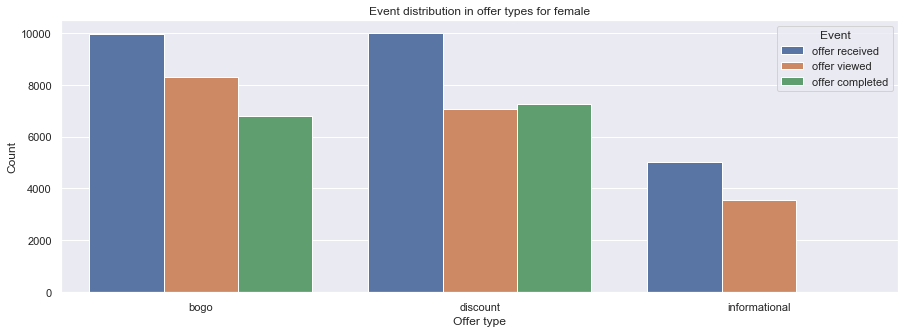

In [85]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "event", data=merged_df[merged_df['gender'] == 'F'])
sns.set(style="darkgrid")
plt.title('Event distribution in offer types for female')
plt.ylabel('Count')
plt.xlabel('Offer type')
plt.legend(title='Event')

## 2. Modeling

In [168]:
models = {'Model': ['KNeighborsClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier', 'DecisionTreeClassifier(tuned)'], 
          'train F1 score':[train_f1_1, train_f1_2, train_f1_3, train_f1_best], 
          'test F1 score': [test_f1_1, test_f1_2, test_f1_3, test_f1_best] }
          
print(pd.DataFrame(models))

                           Model  train F1 score  test F1 score
0           KNeighborsClassifier       51.399978      28.767341
1         RandomForestClassifier       93.053285      68.658138
2         DecisionTreeClassifier       93.941366      84.813181
3  DecisionTreeClassifier(tuned)       92.346947      92.117711


The validation set (test data set) is used to evaluate the model. Both RandomForestClassifier and DecisionTreeClassifier based  models are better than the KNeighborsClassifier based model. The best score is created by the DecisionTreeClassifier model, as its validate F1 score is 84.78 and after hyperparameter tunning, we get improved F1 score to be 92.12.
The RandomForestClassifier model scores good as well compared to the first model, with a test F1 score of 69.01. 
Based on the nature of the problem to solve, it does not require very high F1 score, so the model can be used for the classification purpose to predict whether a customer will respond to an offer or not.